## Getting Started

In the following we like to introduce *pymoo* by presenting an example optimization scenario. This guide goes through the most important steps to get started with our framework. First, we present an example optimization problem to be solved using *pymoo*. Second, we show how to formulate the optimization problem in our framework and how to instantiate an algorithm object to be used for optimization. Then, a termination criterion for the algorithm is defined and the optimization method is called. Finally, we quickly show a possible post-processing step which analyzes the optimization run performance.

### Multi-Objective Optimization

In general, multi-objective optimization has several objective functions with subject to inequality and equality constraints to optimize <cite data-cite="multi_objective_book"></cite>. The goal is to find a set of solutions that do not have any constraint violation and are as good as possible regarding all its objectives values. The problem definition in its general form is given by:

\begin{align}
\begin{split}
\min \quad& f_{m}(x) \quad \quad \quad \quad m = 1,..,M  \\[4pt]
\text{s.t.}   \quad& g_{j}(x) \leq 0  \quad \; \; \,  \quad j = 1,..,J \\[2pt]
\quad& h_{k}(x) = 0        \quad  \; \; \quad k = 1,..,K \\[4pt]
\quad& x_{i}^{L} \leq x_{i} \leq x_{i}^{U}  \quad i = 1,..,N \\[2pt]
\end{split}
\end{align}

The formulation above defines a multi-objective optimization problem with $N$ variables, $M$ objectives, $J$ inequality and $K$ equality constraints. Moreover, for each variable $x_i$ lower and upper variable boundaries ($x_i^L$ and $x_i^U$) are defined.

### Example Optimization Problem

In the following, we investigate exemplarily a bi-objective optimization with two constraints. 
The selection of a suitable optimization problem was made based on having enough complexity for the purpose of demonstration, but not being too difficult to lose track of the overall idea. Its definition is given by:

\begin{align} 
\begin{split}
\min \;\; & f_1(x) = (x_1^2 + x_2^2) \\ 
\max \;\; & f_2(x) = -(x_1-1)^2 - x_2^2 \\[1mm]
\text{s.t.} \;\; & g_1(x) = 2 \, (x_1 - 0.1) \, (x_1 - 0.9) \leq 0\\ 
& g_2(x) = 20 \, (x_1 - 0.4) \, (x_1 - 0.6) \geq 0\\[1mm] 
& -2 \leq x_1 \leq 2 \\
& -2 \leq x_2 \leq 2
\end{split}
\end{align}

 It consists of two objectives ($M=2$) where $f_1(x)$ is minimized and $f_2(x)$ maximized. The optimization is with subject to two inequality constraints ($J=2$) where $g_1(x)$ is formulated as a less than and $g_2(x)$ as a greater than constraint. The problem is defined with respect to two variables ($N=2$), $x_1$ and $x_2$, which both are in the range $[-2,2]$. The problem does not contain any equality constraints ($K=0$). 

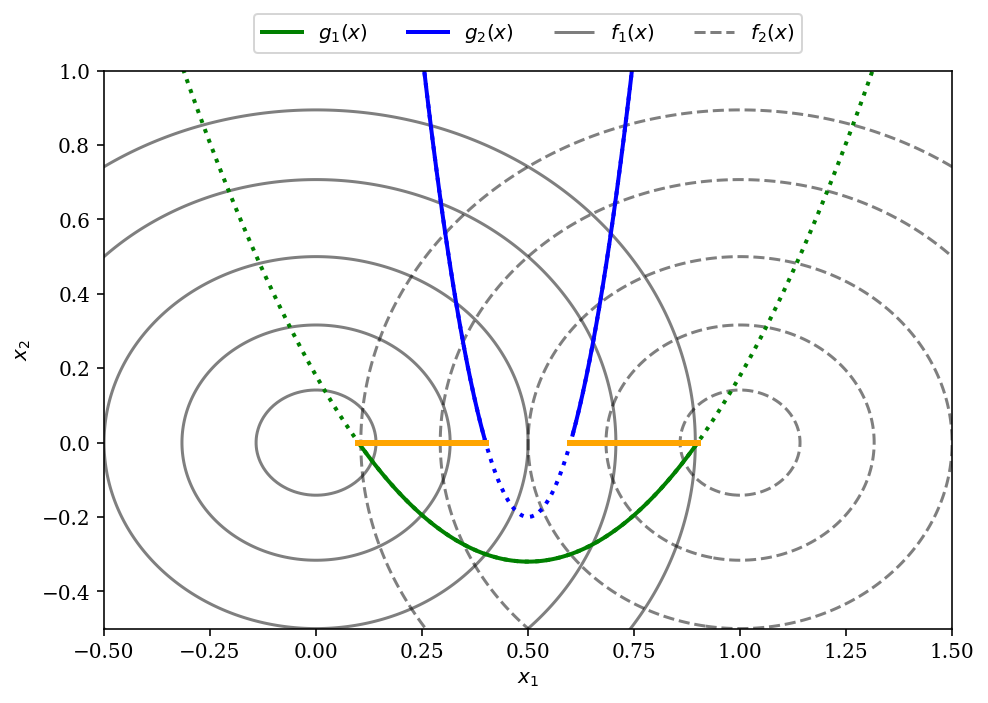

In [1]:
import numpy as np

X1, X2 = np.meshgrid(np.linspace(-2, 2, 500), np.linspace(-2, 2, 500))

F1 = X1**2 + X2**2
F2 = (X1-1)**2 + X2**2
G = X1**2 - X1 + 3/16

G1 = 2 * (X1[0] - 0.1) * (X1[0] - 0.9)
G2 = 20 * (X1[0] - 0.4) * (X1[0] - 0.6)


import matplotlib.pyplot as plt
plt.rc('font', family='serif')

levels = [0.02, 0.1, 0.25, 0.5, 0.8]
plt.figure(figsize=(7, 5))
CS = plt.contour(X1, X2, F1, levels, colors='black', alpha=0.5)
CS.collections[0].set_label("$f_1(x)$")

CS = plt.contour(X1, X2, F2, levels, linestyles="dashed", colors='black', alpha=0.5)
CS.collections[0].set_label("$f_2(x)$")

plt.plot(X1[0], G1, linewidth=2.0, color="green", linestyle='dotted')
plt.plot(X1[0][G1<0], G1[G1<0], label="$g_1(x)$", linewidth=2.0, color="green")

plt.plot(X1[0], G2, linewidth=2.0, color="blue", linestyle='dotted')
plt.plot(X1[0][X1[0]>0.6], G2[X1[0]>0.6], label="$g_2(x)$",linewidth=2.0, color="blue")
plt.plot(X1[0][X1[0]<0.4], G2[X1[0]<0.4], linewidth=2.0, color="blue")

plt.plot(np.linspace(0.1,0.4,100), np.zeros(100),linewidth=3.0, color="orange")
plt.plot(np.linspace(0.6,0.9,100), np.zeros(100),linewidth=3.0, color="orange")

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
          ncol=4, fancybox=True, shadow=False)

plt.tight_layout()
plt.show()

The figure above shows the contours of the problem. The contour lines of the objective function $f_1(x)$ is represented by a solid and $f_2(x)$ by a dashed line. The constraints $g_1(x)$ and $g_2(x)$ are parabolas which intersect the $x_1$-axis at $(0.1, 0.9)$ and $(0.4, 0.6)$. The pareto-optimal set is illustrated by a thick orange line. Through the combination of both constraints the pareto-set is split into two parts.
Analytically, the pareto-optimal set is  given by $PS = \{(x_1, x_2) \,|\, (0.1 \leq x_1 \leq 0.4) \lor (0.6 \leq x_1 \leq 0.9) \, \land \, x_2 = 0\}$ and the Pareto-front by $f_2 = (\sqrt{f_1} - 1)^2$ where $f_1$ is defined in $[0.01,0.16]$ and $[0.36,0.81]$.  



### Problem Definition

In *pymoo*, we consider pure minimization problems for optimization in all our modules. However, without loss of generality an objective which is supposed to be maximized, can be multiplied by $-1$ and be minimized. Therefore, we minimize $-f_2(x)$ instead of maximizing $f_2(x)$ in our optimization problem. Furthermore, all constraint functions need to be formulated as a $\leq 0$ constraint. 
The feasibility of a solution can, therefore, be expressed by:

$$ \begin{cases}
\text{feasible,} \quad \quad \sum_i^n \langle g_i(x)\rangle = 0\\
\text{infeasbile,} \quad \quad \quad \text{otherwise}\\
\end{cases}
$$

$$
\text{where} \quad \langle g_i(x)\rangle =
\begin{cases}
0, \quad \quad \; \text{if} \; g_i(x) \leq 0\\
g_i(x), \quad  \text{otherwise}\\
\end{cases}
$$


For this reason, $g_2(x)$ needs to be multiplied by $-1$ in order to flip the $\geq$ to a $\leq$ relation. We recommend the normalization of constraints to give equal importance to each of them. 
For $g_1(x)$, the coefficient results in $2 \cdot (-0.1) \cdot (-0.9) = 0.18$ and for $g_2(x)$ in $20 \cdot (-0.4) \cdot (-0.6) = 4.8$, respectively. We achieve normalization of constraints by dividing $g_1(x)$ and $g_2(x)$ by its corresponding coefficient.



Finally, the optimization problem to be optimized using *pymoo* is defined by:

\begin{align} 
\label{eq:getting_started_pymoo}
\begin{split}
\min \;\; & f_1(x) = (x_1^2 + x_2^2) \\ 
\min \;\; & f_2(x) = (x_1-1)^2 + x_2^2 \\[1mm] 
\text{s.t.} \;\; & g_1(x) = 2 \, (x_1 - 0.1) \, (x_1 - 0.9)  \, /  \,  0.18 \leq 0\\ 
& g_2(x) = - 20 \, (x_1 - 0.4) \, (x_1 - 0.6) \,  /  \,  4.8 \leq 0\\[1mm] 
& -2 \leq x_1 \leq 2 \\
& -2 \leq x_2 \leq 2
\end{split}
\end{align}



Next, the derived problem formulation is implemented in Python. Each optimization problem in *pymoo* has to inherit from the *Problem* class. First, by calling the super() function the problem properties such as the number of variables (n_var), objectives (n_obj) and constraints (n_constr) are initialized. Furthermore, lower (xl) and upper variables boundaries (xu) are supplied as a NumPy array. Additionally, the evaluation function _evaluate needs to be overwritten from the superclass. 
The method takes a two-dimensional NumPy array x with n rows and m columns as an input. Each row represents an individual and each column an optimization variable. After doing the necessary calculations, the objective values have to be added to the dictionary out with the key F and the constraints with key G.


In [2]:
import autograd.numpy as anp
import numpy as np
from pymoo.util.misc import stack
from pymoo.model.problem import Problem

class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=2, 
                         n_obj=2, 
                         n_constr=2, 
                         xl=anp.array([-2,-2]), 
                         xu=anp.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:,0]**2 + x[:,1]**2
        f2 = (x[:,0]-1)**2 + x[:,1]**2
        
        g1 = 2*(x[:, 0]-0.1) * (x[:, 0]-0.9) / 0.18
        g2 = - 20*(x[:, 0]-0.4) * (x[:, 0]-0.6) / 4.8
        
        out["F"] = anp.column_stack([f1, f2])
        out["G"] = anp.column_stack([g1, g2])

        
    # --------------------------------------------------
    # Pareto-front - not necessary but used for plotting
    # --------------------------------------------------
    def _calc_pareto_front(self, flatten=True, **kwargs):
        f1_a = np.linspace(0.1**2, 0.4**2, 100)
        f2_a = (np.sqrt(f1_a) - 1)**2
        
        f1_b = np.linspace(0.6**2, 0.9**2, 100)
        f2_b = (np.sqrt(f1_b) - 1)**2
        
        a, b = np.column_stack([f1_a, f2_a]), np.column_stack([f1_b, f2_b])
        return stack(a, b, flatten=flatten)
    
    # --------------------------------------------------
    # Pareto-set - not necessary but used for plotting
    # --------------------------------------------------
    def _calc_pareto_set(self, flatten=True, **kwargs):
        x1_a = np.linspace(0.1, 0.4, 50)
        x1_b = np.linspace(0.6, 0.9, 50)
        x2 = np.zeros(50)
        
        a, b = np.column_stack([x1_a, x2]), np.column_stack([x1_b, x2])
        return stack(a,b, flatten=flatten)
    
problem = MyProblem()


Because we consider a test problem where the optimal solutions in design and objective space are known, we have implemented the _calc_pareto_front and _calc_pareto_set functions to observe the convergence of the algorithm later on. For the optimization run itself the methods need not to be overwritten. So, no worries if you are investigating benchmark or real-world optimization problems.

Moreover, we would like to mention that in many test optimization problems implementation already exist. For example, the test problem *ZDT1* can be initiated by:

In [3]:
from pymoo.factory import get_problem

zdt1 = get_problem("zdt1")

Our framework has various single- and many-objective optimization test problems already implemented. Furthermore, a more advanced guide for custom problem definitions is available. In case problem functions are computationally expensive, parallelization of the evaluations functions might be an option.

[Optimization Test Problems](problems/index.ipynb) | 
[Define a Custom Problem](problems/custom.ipynb) | 
[Parallelization](problems/parallelization.ipynb)


### Initialize an Algorithm




Moreover, we need to initialize a method to optimize the problem.
In *pymoo* factory methods create an algorithm object to be used for optimization. For each of those methods an API documentation is available and through supplying different parameters, algorithms can be customized in a plug-and-play manner.
Depending on the optimization problem different algorithms can be used to optimize the problem. Our framework offers various [Algorithms](algorithms/index.ipynb) which can be used to solve problems with different characteristics.

In general, the choice of a suitable algorithm for optimization problems is a challenge itself. Whenever problem characteristics are known beforehand, we recommended using those through customized operators.
However, in our case the optimization problem is rather simple, but the aspect of having two objectives and two constraints should be considered. For this reason, we decided to use [NSGA-II](algorithms/nsga2.ipynb) with its default configuration with minor modifications. We chose a population size of $20$ and decided instead of generating the same number of offsprings to create only one fourth  of it, namely $5$. This is a greedier  variant and improves the convergence of rather simple optimization problems without difficulties regarding optimization, such as the existence of local Pareto fronts.
Moreover, we enable a duplicate check which makes sure that the mating produces offsprings which are different with respect to themselves and the existing population regarding their design space values. To illustrate the customization aspect, we listed the other unmodified default operators in the code-snippet below. The factory method *nsga2* with the supplied parameters returns an initialized algorithm objective.


In [33]:
from pymoo.algorithms.nsga2 import nsga2
from pymoo.factory import get_sampling, get_crossover, get_mutation

algorithm = nsga2(pop_size=50,
               n_offsprings=20,
               sampling=get_sampling("real_random"),
               crossover=get_crossover("real_sbx", prob=0.9, eta=15),
               mutation=get_mutation("real_pm", eta=20),
               eliminate_duplicates=True
               )

The algorithm object contains the implementation of NSGA-II  with the custom settings supplied to the factory method.

### Define a Termination Criterion

Furthermore, a termination criterion needs to be defined to finally start the optimization procedure. Different kind of [Termination Criteria](misc/termination_criterion.ipynb) are available. Here, since the problem is rather simple, we run the algorithm for some number of generations. 

In [34]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 30)

Instead of number of generations (or iterations) other criteria such as the number of function evaluations or the improvement in design or objective space from the last to the current generation can be used.

### Optimize

Finally, we are solving the problem with the algorithm and termination criterion we have defined. 

In [38]:
import matplotlib.pyplot as plt

from pymoo.optimize import minimize
from pymoo.util import plotting

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               pf=problem.pareto_front(use_cache=False),
               save_history=True,
               verbose=True)


n_gen | n_eval  | cv (min/avg)                | igd          | gd           | hv          
1     | 50      | 0.0000000000 / 1.925253E+01 | 3.2244674112 | 3.4286374276 | 0.0000000000
2     | 70      | 0.0000000000 / 8.0002734121 | 0.3030197942 | 2.0649760158 | 0.1892830993
3     | 90      | 0.0000000000 / 2.8707725734 | 0.2090924748 | 1.8279728408 | 0.2536796825
4     | 110     | 0.0000000000 / 0.7656409944 | 0.1557302707 | 1.6495420291 | 0.3046267934
5     | 130     | 0.0000000000 / 0.0190346440 | 0.1322220702 | 1.4376607283 | 0.3398557061
6     | 150     | 0.0000000000 / 0.0008666613 | 0.0894253968 | 1.4322013417 | 0.3868300879
7     | 170     | 0.0000000000 / 0.0000000000 | 0.0745495917 | 0.6856564567 | 0.3928424549
8     | 190     | 0.0000000000 / 0.0000000000 | 0.0622766400 | 0.2644848924 | 0.3928498610
9     | 210     | 0.0000000000 / 0.0000000000 | 0.0478481441 | 0.1664068862 | 0.4098303207
10    | 230     | 0.0000000000 / 0.0000000000 | 0.0410385204 | 0.1116723699 | 0.4159744312

The [Result](/api/model.html#pymoo.model.result.Result) object provides the corresponding X and F values and some more information.

### Visualize

The optimization results are illustrated below (design and objective space). The solid line represents the analytically derived Pareto set and front in the corresponding space and the circles solutions found by the algorithm. It can be observed that the algorithm was able to converge and a set of nearly-optimal solutions was obtained. 

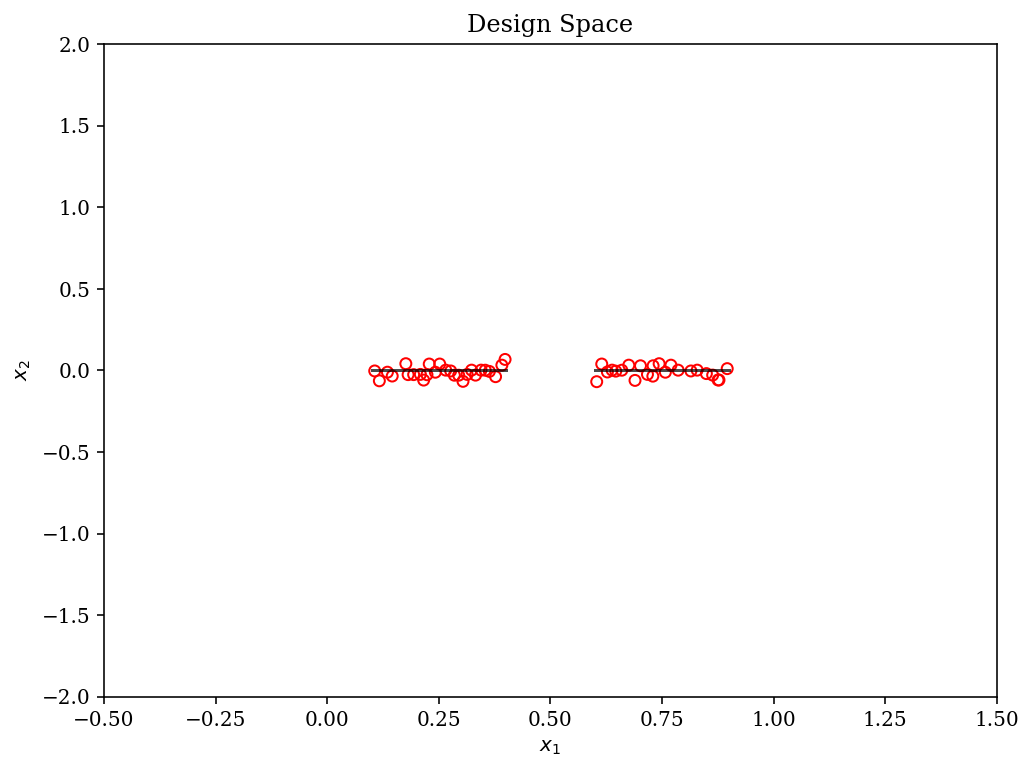

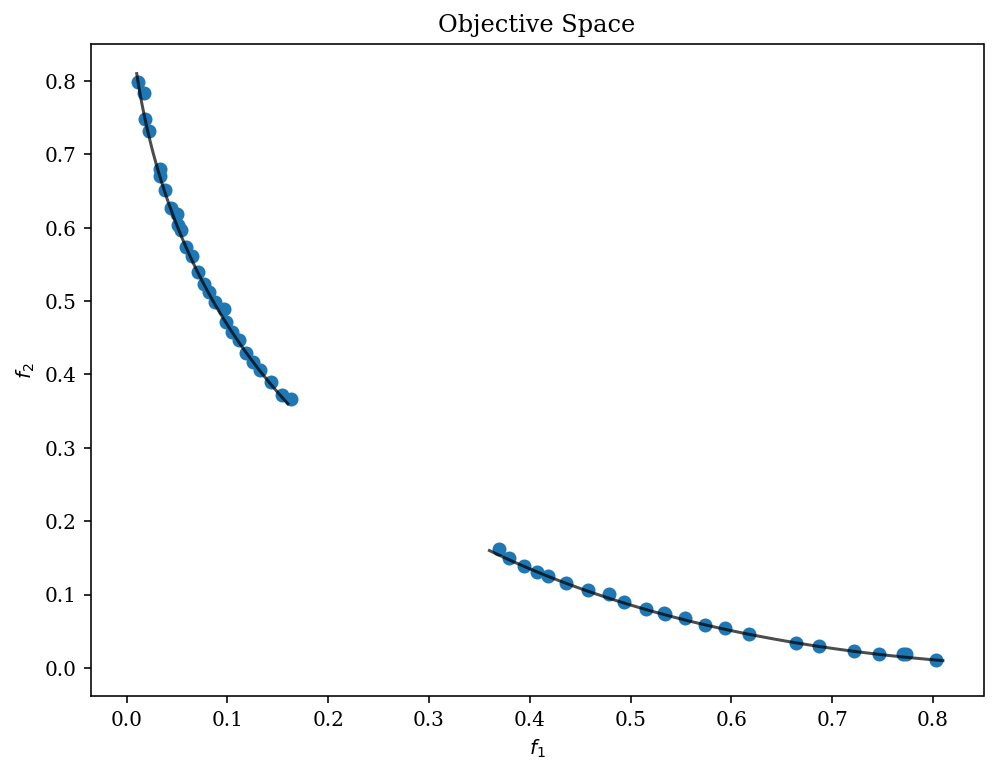

In [36]:
from pymoo.visualization.scatter import scatter

# get the pareto-set and pareto-front for plotting
ps = problem.pareto_set(use_cache=False, flatten=False)
pf = problem.pareto_front(use_cache=False, flatten=False)

# Design Space
plot = scatter(title = "Design Space", axis_labels="x")
plot.add(res.X, s=30, facecolors='none', edgecolors='r')
plot.add(ps, plot_type="line", color="black", alpha=0.7)
plot.do()
plot.apply(lambda ax: ax.set_xlim(-0.5, 1.5))
plot.apply(lambda ax: ax.set_ylim(-2, 2))
plot.show()

# Objective Space
plot = scatter(title = "Objective Space")
plot.add(res.F)
plot.add(pf, plot_type="line", color="black", alpha=0.7)
plot.show()

Visualization is an important post-processing step in multi-objective optimization. Although it seems to be pretty easy for our example optimization problem, it becomes much more difficult in higher dimensions where trade-offs between solutions are not easily observable. For visualizations in higher dimensions, various more advanced [Visualizations](visualization/index.ipynb) are implemented in our framework.

### Performance Tracking

If the optimization scenario is repetitive it makes sense to track the performance of the algorithm. Because we have stored the history of the optimization run, we can now analyze the convergence over time. To measure the performance, we need to decide what metric to be used. Here, we are using Hypervolume. Of course, other [Performance Indicators](misc/performance_indicator.ipynb) are available as well.

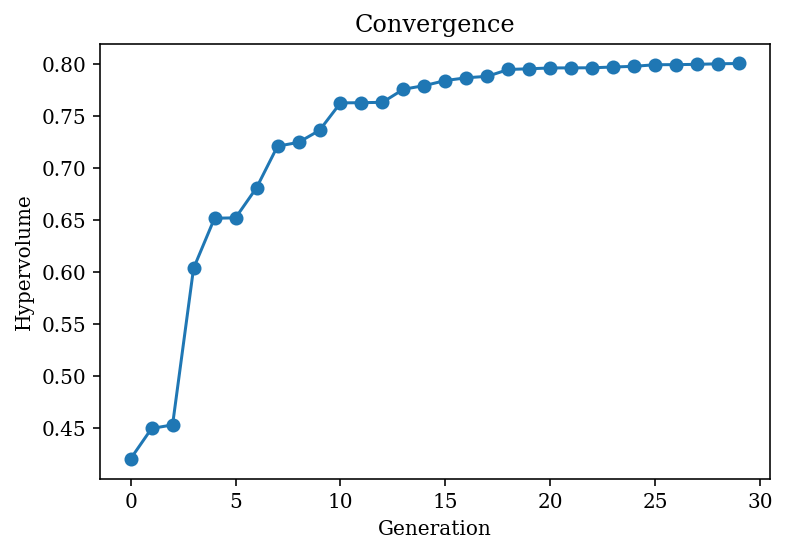

In [37]:
from pymoo.performance_indicator.hv import Hypervolume

# create the performance indicator object with reference point (4,4)
metric = Hypervolume(ref_point=np.array([1.0, 1.0]))

# collect the population in each generation
pop_each_gen = [a.pop for a in res.history]

# receive the population in each generation
obj_and_feasible_each_gen = [pop[pop.get("feasible")[:,0]].get("F") for pop in pop_each_gen]

# calculate for each generation the HV metric
hv = [metric.calc(f) for f in obj_and_feasible_each_gen]

# visualze the convergence curve 
plt.plot(np.arange(len(hv)), hv, '-o')
plt.title("Convergence")
plt.xlabel("Generation")
plt.ylabel("Hypervolume")
plt.show()


We hope you have enjoyed the getting started guide. For more topics we refer to each section covered by on the [landing page](https://pymoo.org). If you have any question or concern do not hesitate to [contact us](contact.rst).